In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import sys
import tensorflow as tf

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
class FfAgentContinuous(object):
    def __init__(self, session, input_size, output_size, gamma=0.99):
        self.session = session
        self.input_size = input_size
        self.output_size = output_size
        self.gamma = gamma
        
        self.observations_ph = tf.placeholder(dtype=tf.float32, shape=[None, self.input_size])
        # expected sum of discounted rewards
        self.esdr_ph = tf.placeholder(dtype=tf.float32, shape=[None, 1])
        self.v_s_ph  = tf.placeholder(dtype=tf.float32, shape=[None, 1]) # V(s)
        self.v_sp_ph = tf.placeholder(dtype=tf.float32, shape=[None, 1]) # V(s')
        self.r_ph    = tf.placeholder(dtype=tf.float32, shape=[None, 1]) # r_t+1
        self.actions_ph = tf.placeholder(dtype=tf.float32, shape=[None, self.output_size])
        #self.reward_ph = tf.placeholder(dtype=tf.float32, shape=[None, 1])
        
        advantage = self.esdr_ph - self.v_s_ph
        mean_adv = tf.reduce_mean(advantage)
        stddev_adv = mean_adv*mean_adv - tf.reduce_mean(advantage*advantage)
        self.adv_normalized = (advantage - mean_adv)/stddev_adv
        
        # Shared-parameter policy and value network
        W1 = tf.get_variable("w1", [self.input_size, 128], initializer=tf.initializers.random_normal(stddev=0.01))
        b1 = tf.get_variable("b1", [128], initializer=tf.initializers.random_normal(stddev=0.01))
        W2p_means = tf.get_variable("w2pmeans", [128, self.output_size], initializer=tf.initializers.random_normal(stddev=0.01)) # policy
        W2p_stdevs = tf.get_variable("w2pstdevs", [128, self.output_size], initializer=tf.initializers.random_normal(stddev=0.01)) # policy
        b2p_means = tf.get_variable("b2pmeans", [self.output_size], initializer=tf.initializers.random_normal(stddev=0.01))
        b2p_stdevs = tf.get_variable("b2pstdevs", [self.output_size], initializer=tf.initializers.random_normal(stddev=0.01))
        W2v = tf.get_variable("w2v", [128, 1], initializer=tf.initializers.random_normal(stddev=0.01)) # value
        b2v = tf.get_variable("b2v", [1], initializer=tf.initializers.random_normal(stddev=0.01))
        
        l1 = tf.nn.relu(tf.matmul(self.observations_ph, W1) + b1)
        # this will need to be changed to accommodate the range and character of action values
        l2_means = tf.matmul(l1, W2p_means) + b2p_means
        # Trying to start with a large standard deviation to encourage exploration early on.
        l2_stdevs = tf.matmul(l1, W2p_stdevs) + b2p_stdevs + 2.5
        l2_policy_means = 2*tf.nn.tanh(l2_means)
        l2_policy_stdevs = tf.math.minimum(tf.nn.softplus(l2_stdevs), 10)
        l2v = tf.matmul(l1, W2v) + b2v
        
        self.reinforce_loss = tf.reduce_mean(
            (self.esdr_ph)*tf.square((self.actions_ph - l2_policy_means)/(l2_policy_stdevs + 1e-8))
            - 1e-4*tf.log(l2_policy_stdevs)
        )
        self.reinforce_optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(self.reinforce_loss)
        
        self.actor_critic_loss = tf.reduce_mean(
            (self.adv_normalized)*tf.square((self.actions_ph - l2_policy_means)/(l2_policy_stdevs + 1e-8))
        ) + tf.reduce_mean(tf.square(l2v - self.esdr_ph) - 1e-4*tf.log(l2_policy_stdevs)) 
        optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
        grads_and_vars = optimizer.compute_gradients(self.actor_critic_loss)
        capped_grads = [(grad if grad is None else tf.clip_by_norm(grad, 2.0), var) for grad, var in grads_and_vars]
        self.actor_critic_optimizer = optimizer.apply_gradients(capped_grads)
        
        self.action_prediction_means = l2_policy_means
        self.action_prediction_stdevs = l2_policy_stdevs
        self.esdr_predictions = l2v
        
    # For advantage:
    #    Add single timestep reward samples
    #    Add placeholders for estimated V(s) and V(s')
    def trainSarBatches(self, states, actions, discounted_rewards):
        '''
        Expects inputs to be numpy arrays of shape:
            states = [batch_size, num_state_features]
            actions = [batch_size, num_available_actions]
            discounted_rewards = [batch_size, 1]
        
        The idea is that all episodes have been parsed through and shuffled into
        one big batch of training data.
        '''
        
        advantage_feeds = {
            self.observations_ph: states
        }
        #print("shape of discounted rewards:", discounted_rewards.shape)
        
        advantage_fetches = self.esdr_predictions
        
        v_predictions = self.session.run(advantage_fetches, feed_dict=advantage_feeds)
        #print(v_predictions.shape)
        
        optimize_feeds = {
            self.observations_ph: states,
            self.esdr_ph: discounted_rewards,
            self.v_s_ph: v_predictions,
            self.actions_ph: actions
        }
        
        optimize_fetches = [
            #self.reinforce_loss,
            self.actor_critic_loss,
            self.action_prediction_means,
            self.action_prediction_stdevs,
            self.esdr_predictions,
            #self.reinforce_optimizer
            self.actor_critic_optimizer
        ]
        
        loss, action_prediction_means, action_prediction_stdevs, esdr_predictions, _ = self.session.run(optimize_fetches, feed_dict=optimize_feeds)
        return loss, action_prediction_means, action_prediction_stdevs, esdr_predictions
    
    def predict(self, state):
        '''
        Expects state to have the shape [num_state_features]
        '''
        
        feeds = {
            self.observations_ph: np.array([state])
        }
        #print("state received by agent:", state)
        fetches = [
            self.action_prediction_means,
            self.action_prediction_stdevs,
            self.esdr_predictions
        ]
        action_prediction_means, action_prediction_stdevs, esdr_predictions = self.session.run(fetches, feed_dict=feeds)
        return action_prediction_means, action_prediction_stdevs, esdr_predictions

In [3]:
def prepSarData(states, actions, rewards, gamma=0.99):
    '''
    Converts temporally synced lists of states, actions, and rewards into shuffled
    numpy matrices for training.
    '''
    #print(len(states), len(actions), len(rewards))
    discounted_sum_rewards = 0
    discounted_rewards = []
    for i in range(len(rewards) - 1, -1, -1):
        discounted_sum_rewards = gamma*discounted_sum_rewards + rewards[i]
        discounted_rewards.append(discounted_sum_rewards)
    discounted_rewards = np.expand_dims(np.array(discounted_rewards[::-1]), axis=1)
    
    actions = np.array(actions)
    states = np.array(states)
    indices = [i for i in range(len(actions))]
    np.random.shuffle(indices)
    
    actions_shuffled = actions[indices]
    states_shuffled = states[indices]
    discounted_rewards_shuffled = discounted_rewards[indices]
    
    return actions_shuffled, states_shuffled, discounted_rewards_shuffled

In [4]:
def accumulateData(env, agent, max_steps=1000, max_rollouts=50):
    states = []
    actions = []
    rewards = []
    for rollout_count in range(max_rollouts):
        ep_states = []
        ep_actions = []
        ep_rewards = []
        ep_state_t = env.reset()
        ep_states.append(ep_state_t)
        for t in range(max_steps):
            ep_action_t = np.random.normal(loc=agent.predict(ep_state_t)[0][0], scale=agent.predict(ep_state_t)[1][0])
            #print(ep_action_t)
            ep_action_t = min(max(ep_action_t, [-2.0]), [2.0])
            #print(ep_action_t)
            ep_state_tp1, ep_reward_tp1, done, _ = env.step(ep_action_t)

            ep_actions.append(ep_action_t)
            ep_states.append(ep_state_tp1)
            ep_rewards.append(ep_reward_tp1)
            if done:
                ep_states.pop(-1)
                #ep_rewards.pop(-1)
                break
            ep_state_t = ep_state_tp1
        states.append(ep_states)
        actions.append(ep_actions)
        rewards.append(ep_rewards)
    return states, actions, rewards

In [5]:
def renderAgent(env, agent):
    state_t = env.reset()
    rewards = 0
    actions = []
    while i < 1000:
        action_t = np.random.normal(loc=agent.predict(state_t)[0][0], scale=agent.predict(state_t)[1][0])
        #print(ep_action_t)
        action_t = min(max(action_t, [-2.0]), [2.0])
        actions.append(action_t)
        #print(ep_action_t)
        state_tp1, reward_tp1, done, _ = env.step(action_t)
        rewards += reward_tp1
        env.render()
        state_t = state_tp1
        if done:
            print("Rewards from rendering:", rewards)
            break
    return actions

In [6]:
#print(type(gym.envs.registry.all()))
env_ids = [espec.id for espec in gym.envs.registry.all()]
for e in sorted(env_ids):
    print(e)


Acrobot-v1
AirRaid-ram-v0
AirRaid-ram-v4
AirRaid-ramDeterministic-v0
AirRaid-ramDeterministic-v4
AirRaid-ramNoFrameskip-v0
AirRaid-ramNoFrameskip-v4
AirRaid-v0
AirRaid-v4
AirRaidDeterministic-v0
AirRaidDeterministic-v4
AirRaidNoFrameskip-v0
AirRaidNoFrameskip-v4
Alien-ram-v0
Alien-ram-v4
Alien-ramDeterministic-v0
Alien-ramDeterministic-v4
Alien-ramNoFrameskip-v0
Alien-ramNoFrameskip-v4
Alien-v0
Alien-v4
AlienDeterministic-v0
AlienDeterministic-v4
AlienNoFrameskip-v0
AlienNoFrameskip-v4
Amidar-ram-v0
Amidar-ram-v4
Amidar-ramDeterministic-v0
Amidar-ramDeterministic-v4
Amidar-ramNoFrameskip-v0
Amidar-ramNoFrameskip-v4
Amidar-v0
Amidar-v4
AmidarDeterministic-v0
AmidarDeterministic-v4
AmidarNoFrameskip-v0
AmidarNoFrameskip-v4
Ant-v2
Assault-ram-v0
Assault-ram-v4
Assault-ramDeterministic-v0
Assault-ramDeterministic-v4
Assault-ramNoFrameskip-v0
Assault-ramNoFrameskip-v4
Assault-v0
Assault-v4
AssaultDeterministic-v0
AssaultDeterministic-v4
AssaultNoFrameskip-v0
AssaultNoFrameskip-v4
Asterix-ra

In [7]:
pendulum = gym.make("Pendulum-v0")
session = tf.Session()
print(pendulum.observation_space.shape)
print(pendulum.action_space)
num_actions = len(pendulum.action_space.high)
agent = FfAgentContinuous(session, pendulum.observation_space.shape[0], num_actions)

session.run(tf.global_variables_initializer())

/home/jg/.local/lib/python3.5/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
(3,)
Box(1,)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


0
average reward:  -1259.6262837793088 stdevs: 1.7072116 losses: 89601.14
1
average reward:  -1198.0482960652357 stdevs: 1.7072487 losses: 219800.64
2
average reward:  -1208.1487040439843 stdevs: 1.708788 losses: 94128.9
3
average reward:  -1249.3051311894517 stdevs: 1.711145 losses: 98434.56
4
average reward:  -1280.1207021780365 stdevs: 1.7149216 losses: 147166.45
5
average reward:  -1249.0351102166005 stdevs: 1.7215877 losses: 79969.234
6
average reward:  -1168.9262095398337 stdevs: 1.7309326 losses: 69794.2
7
average reward:  -1291.2013054931324 stdevs: 1.7471824 losses: 78864.56
8
average reward:  -1207.2023070282698 stdevs: 1.7628632 losses: 154599.08
9
average reward:  -1209.2076500533456 stdevs: 1.7759403 losses: 139370.1
Rewards from rendering: -1620.1662111842754


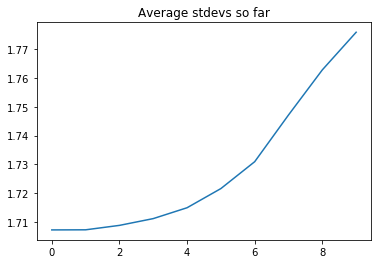

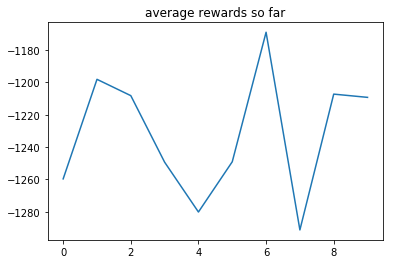

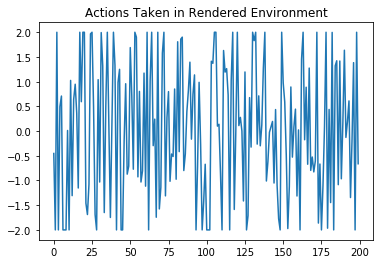

10
average reward:  -1199.4240834654927 stdevs: 1.771084 losses: 149791.19
11
average reward:  -1111.5083439853674 stdevs: 1.7739646 losses: 129892.25
12
average reward:  -1169.9944692429694 stdevs: 1.7638265 losses: 104379.74
13
average reward:  -1246.6191486901955 stdevs: 1.7665379 losses: 159360.05
14
average reward:  -1277.2023424497427 stdevs: 1.77037 losses: 109136.94
15
average reward:  -1274.326698472563 stdevs: 1.7144853 losses: 163963.86
16
average reward:  -1315.5234633687555 stdevs: 1.5998286 losses: 190493.38
17
average reward:  -1321.7898602859786 stdevs: 1.486875 losses: 177336.8
18
average reward:  -1379.6929136874862 stdevs: 1.3380225 losses: 184094.77
19
average reward:  -1421.1179053134806 stdevs: 1.4217389 losses: 185466.42
Rewards from rendering: -1474.402033623479


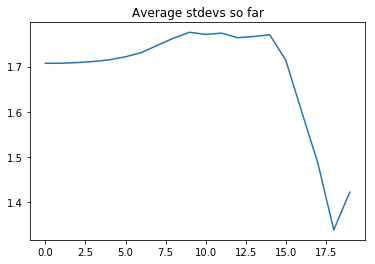

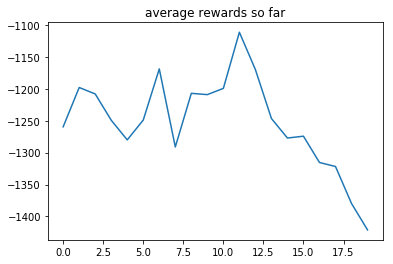

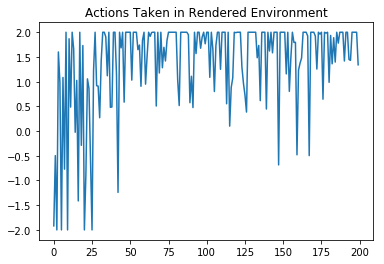

20
average reward:  -1451.2785497264829 stdevs: 1.0196949 losses: 218461.73
21
average reward:  -1482.8390107160421 stdevs: 0.82506067 losses: 233127.12
22
average reward:  -1496.172559234223 stdevs: 0.8683558 losses: 215509.62
23
average reward:  -1503.1982037194869 stdevs: 0.69570494 losses: 234913.44
24
average reward:  -1534.6133416704874 stdevs: 0.1819857 losses: 258616.56
25
average reward:  -1520.3026646280239 stdevs: 0.22958751 losses: 250603.16
26
average reward:  -1510.2915440484094 stdevs: 1.2136227 losses: 188663.9
27
average reward:  -1552.9572371000002 stdevs: 0.35075647 losses: 246927.23
28
average reward:  -1533.1606082758187 stdevs: 0.025859715 losses: 260054.88
29
average reward:  -1526.6581105842886 stdevs: 0.6011225 losses: 226510.2
Rewards from rendering: -1338.2004442459297


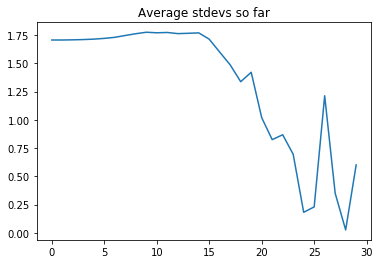

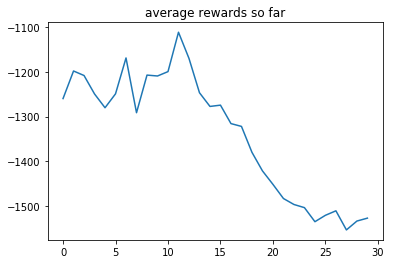

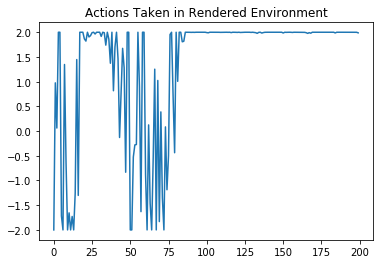

30
average reward:  -1552.212497265649 stdevs: 0.5065973 losses: 237660.66
31
average reward:  -1527.0731639222927 stdevs: 0.6732951 losses: 216331.02
32
average reward:  -1510.5484088847859 stdevs: 0.54939276 losses: 236932.95
33
average reward:  -1533.4198220723326 stdevs: 0.003927902 losses: 256058.84
34
average reward:  -1554.076700229056 stdevs: 0.6072989 losses: 227044.55
35
average reward:  -1554.2406597141214 stdevs: 0.005454806 losses: 256658.5
36
average reward:  -1563.119203908548 stdevs: 0.387381 losses: 233876.34
37
average reward:  -1561.418585271814 stdevs: 0.5099585 losses: 238641.4
38
average reward:  -1563.194826691878 stdevs: 0.02877935 losses: 249607.8
39
average reward:  -1529.036111896646 stdevs: 0.023393735 losses: 253634.64
Rewards from rendering: -1537.4207939082792


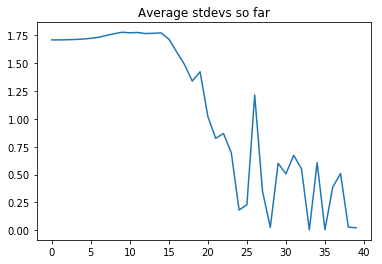

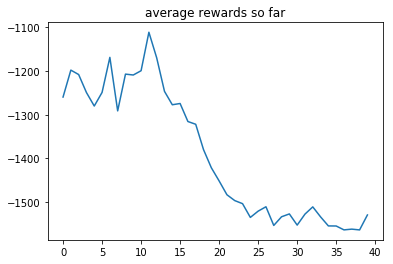

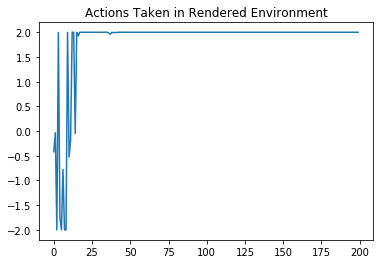

40
average reward:  -1552.6308022457963 stdevs: 0.48069528 losses: 238414.08
41
average reward:  -1564.1139709241868 stdevs: 0.008011095 losses: 247031.36
42
average reward:  -1559.7231508581785 stdevs: 0.31382477 losses: 227939.69
43
average reward:  -1550.560225962056 stdevs: 0.4955016 losses: 202613.56
44
average reward:  -1548.377064189968 stdevs: 0.30318776 losses: 216060.8
45
average reward:  -1538.3228557552554 stdevs: 0.48094532 losses: 242102.52
46
average reward:  -1583.4255370989101 stdevs: 0.71275634 losses: 221311.4
47
average reward:  -1575.1336794675642 stdevs: 0.017186316 losses: 238949.45
48
average reward:  -1549.534483628092 stdevs: 0.0011470518 losses: 222839.7
49
average reward:  -1567.124484970523 stdevs: 0.0005887226 losses: 243153.73
Rewards from rendering: -1490.2742216967902


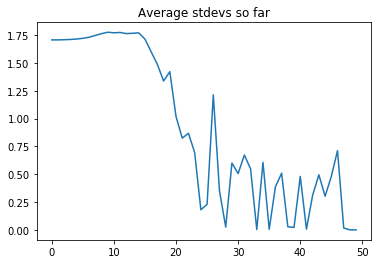

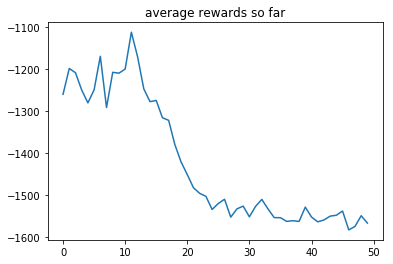

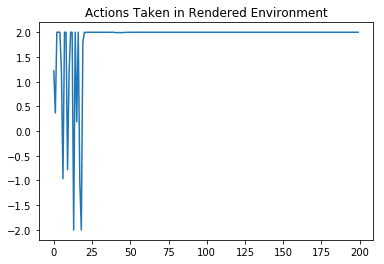

50
average reward:  -1566.3153666445714 stdevs: 0.39625004 losses: 209156.83
51
average reward:  -1547.1480995033187 stdevs: 0.56414205 losses: 234686.56
52
average reward:  -1533.1188067482863 stdevs: 0.7544067 losses: 210777.88
53
average reward:  -1555.6692163272758 stdevs: 0.0022533732 losses: 228599.5
54
average reward:  -1560.3572181439727 stdevs: 0.34224036 losses: 225005.45
55
average reward:  -1578.2673712166975 stdevs: 0.52184385 losses: 221456.44
56
average reward:  -1570.3537126880658 stdevs: 1.5648426 losses: 213718.2
57
average reward:  -1561.8429156403802 stdevs: 0.9587672 losses: 204319.92
58
average reward:  -1529.4722494011146 stdevs: 0.79019487 losses: 218775.64
59
average reward:  -1556.382620344244 stdevs: 0.71574247 losses: 207900.31
Rewards from rendering: -1637.3934188743601


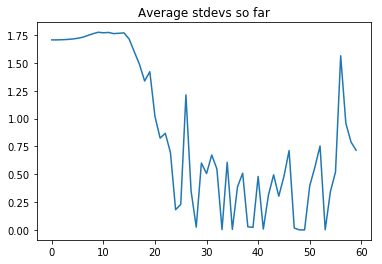

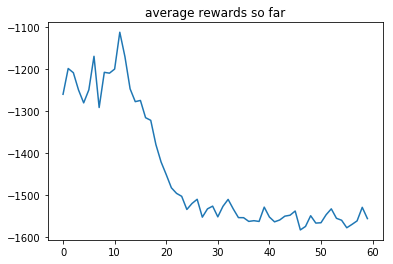

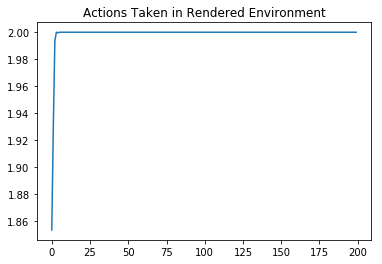

60
average reward:  -1556.2802413166903 stdevs: 0.77896535 losses: 219990.34
61
average reward:  -1526.2164611662565 stdevs: 0.46456462 losses: 197888.27
62
average reward:  -1537.9041881832222 stdevs: 0.005427235 losses: 225188.84
63
average reward:  -1541.641530770765 stdevs: 0.042474784 losses: 224720.05
64
average reward:  -1527.960822969757 stdevs: 0.88779783 losses: 201435.27
65
average reward:  -1548.2756290068264 stdevs: 0.50087714 losses: 192044.88
66
average reward:  -1553.8004606013567 stdevs: 0.0015692493 losses: 223157.94
67
average reward:  -1524.4279779231615 stdevs: 0.003476379 losses: 214615.23
68
average reward:  -1564.4771660883698 stdevs: 0.7262217 losses: 209139.52
69
average reward:  -1547.3951335194333 stdevs: 0.00013348284 losses: 216271.4
Rewards from rendering: -1193.7698360708084


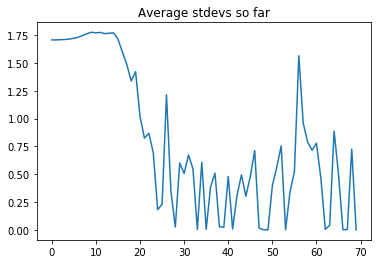

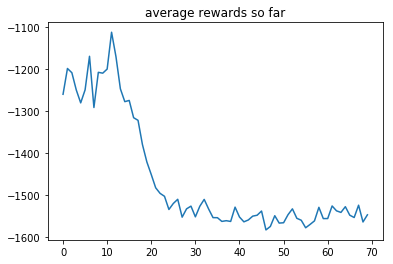

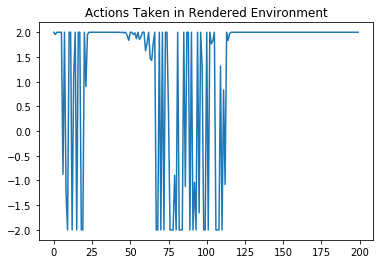

70
average reward:  -1567.0787295666792 stdevs: 0.00020385269 losses: 215490.62
71
average reward:  -1516.5592366352907 stdevs: 0.7182184 losses: 192838.2
72
average reward:  -1568.4584272076363 stdevs: 0.02212796 losses: 207901.27
73
average reward:  -1558.9999888270147 stdevs: 0.7063118 losses: 213851.56
74
average reward:  -1554.984274485209 stdevs: 0.0016618527 losses: 206239.4
75
average reward:  -1553.2506809929637 stdevs: 0.51226884 losses: 164170.3
76
average reward:  -1547.8957705825667 stdevs: 0.00070284685 losses: 205125.72
77
average reward:  -1524.426137029939 stdevs: 0.7193847 losses: 205329.8
78
average reward:  -1553.6512346275451 stdevs: 0.77107465 losses: 195732.88
79
average reward:  -1510.425868362462 stdevs: 0.02751174 losses: 202651.27
Rewards from rendering: -1504.8887802751456


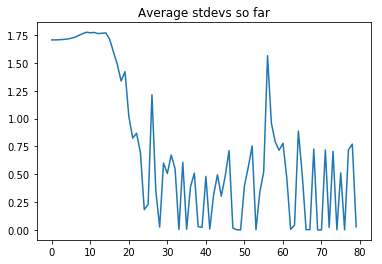

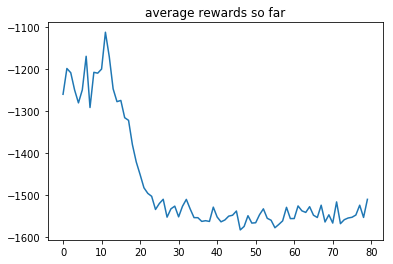

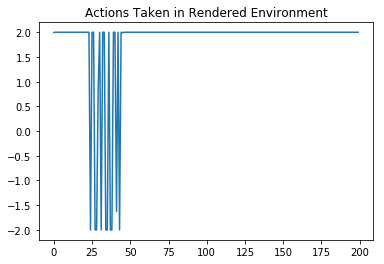

80
average reward:  -1549.0720536732074 stdevs: 0.8366081 losses: 196569.7
81
average reward:  -1567.2862735568604 stdevs: 0.87236345 losses: 202533.0
82
average reward:  -1527.3819821351583 stdevs: 1.4589314 losses: 186857.73
83
average reward:  -1523.3859663817486 stdevs: 0.7494803 losses: 198323.77
84
average reward:  -1539.880142777104 stdevs: 0.013063136 losses: 194882.12
85
average reward:  -1573.312830459469 stdevs: 0.00026108173 losses: 192377.4
86
average reward:  -1566.1500443057894 stdevs: 0.9314118 losses: 179227.95
87
average reward:  -1561.3794437593228 stdevs: 0.9198005 losses: 197797.8
88
average reward:  -1540.976891038326 stdevs: 1.2312233 losses: 181818.84
89
average reward:  -1551.0603435771998 stdevs: 1.1728688 losses: 186390.92
Rewards from rendering: -1469.6656566699214


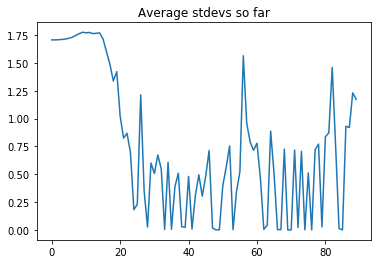

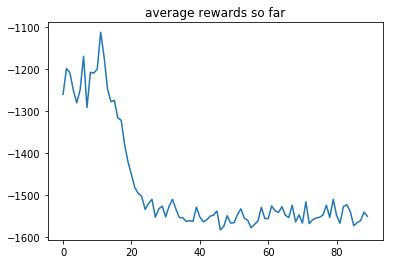

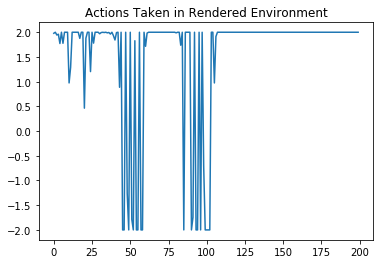

90
average reward:  -1545.3211943856224 stdevs: 0.81597626 losses: 179695.23
91
average reward:  -1554.2264903989262 stdevs: 0.00014994624 losses: 183249.02
92
average reward:  -1553.923360272688 stdevs: 1.3442508 losses: 171650.2
93
average reward:  -1528.0554799864624 stdevs: 0.0001021961 losses: 181987.73
94
average reward:  -1549.210365060332 stdevs: 0.8094873 losses: 171714.05
95
average reward:  -1562.4379763793975 stdevs: 0.004009856 losses: 176619.95
96
average reward:  -1537.2935866623818 stdevs: 1.8095318 losses: 168659.36
97
average reward:  -1536.8461302174044 stdevs: 0.0019657675 losses: 173341.31
98
average reward:  -1542.9580301250257 stdevs: 0.010725759 losses: 170122.28
99
average reward:  -1540.9300793829798 stdevs: 0.8323546 losses: 177870.48
Rewards from rendering: -1613.8810730273642


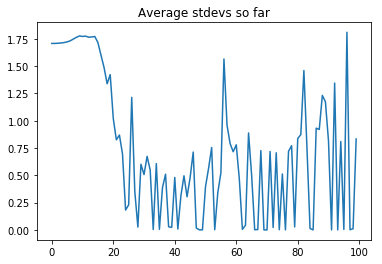

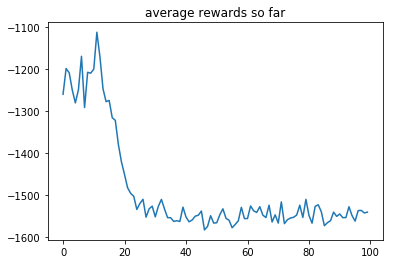

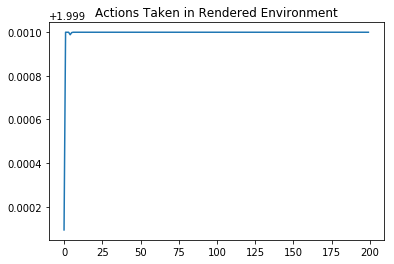

100
average reward:  -1536.1273658638145 stdevs: 5.219443 losses: 140018.69
101
average reward:  -1574.069234060241 stdevs: 1.0880979 losses: 171046.28
102
average reward:  -1570.1089496416273 stdevs: 2.8569832e-05 losses: 166580.31
103
average reward:  -1550.0319186917861 stdevs: 8.259159e-05 losses: 166358.1
104
average reward:  -1572.166702582065 stdevs: 1.5068421 losses: 170209.88
105
average reward:  -1581.2730430759177 stdevs: 0.0056185974 losses: 159068.14
106
average reward:  -1541.1345597240538 stdevs: 1.3323343 losses: 167990.02
107
average reward:  -1553.0085970866674 stdevs: 0.043756105 losses: 150259.12
108
average reward:  -1563.8174599174063 stdevs: 0.74709564 losses: 156738.94
109
average reward:  -1550.2179613700343 stdevs: 0.8401139 losses: 166920.97
Rewards from rendering: -1546.7670882705454


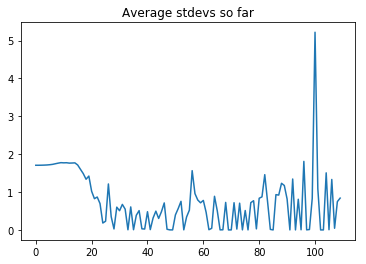

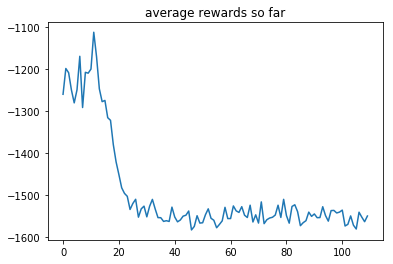

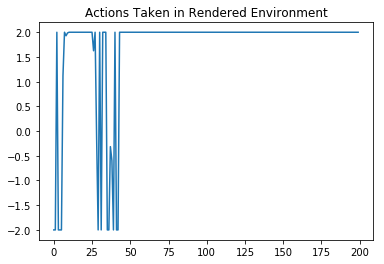

110
average reward:  -1555.3601097791654 stdevs: 0.8796371 losses: 162600.2
111
average reward:  -1545.5206794377432 stdevs: 0.0070492052 losses: 153679.95
112
average reward:  -1547.0852644673187 stdevs: 2.9888873 losses: 132949.84
113
average reward:  -1567.5625631675098 stdevs: 0.0003204678 losses: 149613.56
114
average reward:  -1560.5390574550663 stdevs: 5.0572016e-06 losses: 146891.98
115
average reward:  -1570.7495463778826 stdevs: 1.0308142 losses: 158856.27
116
average reward:  -1556.0928199878842 stdevs: 0.0025890206 losses: 141461.88
117
average reward:  -1563.0024320164935 stdevs: 1.0603662 losses: 146855.62
118
average reward:  -1550.8626757520126 stdevs: 1.278715 losses: 149082.84
119
average reward:  -1552.4624699461 stdevs: 0.014922854 losses: 140514.23
Rewards from rendering: -1607.8153745347552


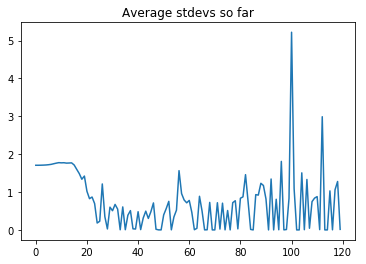

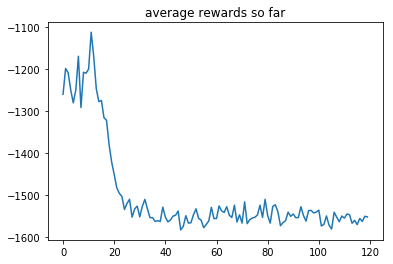

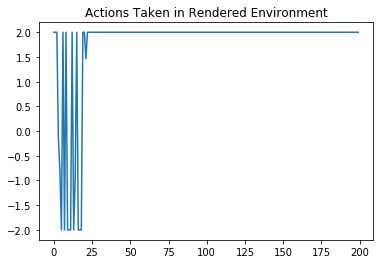

120
average reward:  -1552.8024719454675 stdevs: 1.7755367 losses: 151930.95
121
average reward:  -1562.533841016246 stdevs: 4.258717 losses: 125985.77
122
average reward:  -1554.1130398456921 stdevs: 0.022700017 losses: 135482.1
123
average reward:  -1579.3849536340051 stdevs: 0.94989514 losses: 149665.81
124
average reward:  -1542.3457717884382 stdevs: 1.3063968 losses: 142201.38
125
average reward:  -1549.9369877548909 stdevs: 7.874313e-05 losses: 130319.58
126
average reward:  -1551.3588133278142 stdevs: 1.0038146 losses: 138363.34
127
average reward:  -1557.8668590985449 stdevs: 0.9021709 losses: 141575.6
128
average reward:  -1554.0660521598138 stdevs: 0.8287539 losses: 132693.16
129
average reward:  -1571.9837000904433 stdevs: 0.99433076 losses: 140023.77
Rewards from rendering: -1568.2908457778788


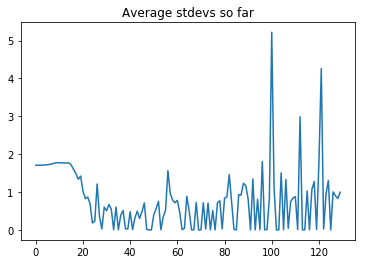

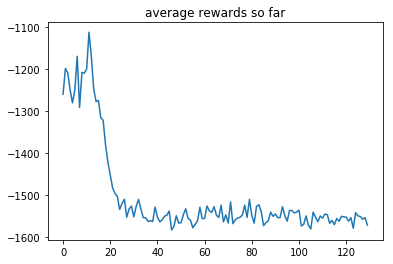

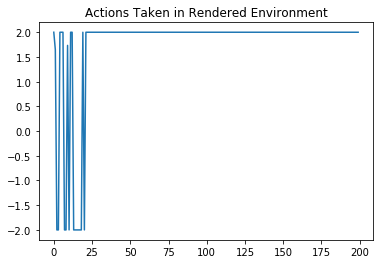

130
average reward:  -1563.3467693524995 stdevs: 0.9094679 losses: 138956.14
131
average reward:  -1537.899302012464 stdevs: 1.2749009 losses: 132859.55
132
average reward:  -1557.4918872645094 stdevs: 1.3115326 losses: 135131.52
133
average reward:  -1586.902348077035 stdevs: 0.9643813 losses: 135891.62
134
average reward:  -1555.7189262907168 stdevs: 0.0002662616 losses: 115497.76
135
average reward:  -1541.1461648503498 stdevs: 0.02826265 losses: 114648.45
136
average reward:  -1564.6760808819702 stdevs: 0.92615676 losses: 134973.69
137
average reward:  -1555.279882377205 stdevs: 0.0030202365 losses: 112954.7
138
average reward:  -1537.68097421492 stdevs: 0.041537713 losses: 111857.88
139
average reward:  -1569.144662118486 stdevs: 1.6607112 losses: 139938.16
Rewards from rendering: -1615.1917623525312


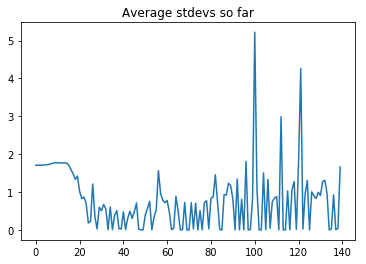

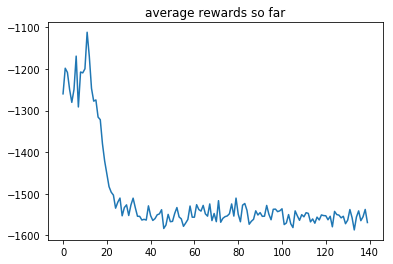

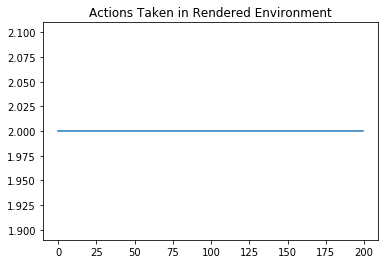

140
average reward:  -1563.1827260824184 stdevs: 1.6648184 losses: 140096.19


In [ ]:
average_rewards = []
average_stdevs = []
for i in range(10000):
    states, actions, rewards = accumulateData(pendulum, agent)
    #print(actions[0:10])
    #print(rewards[0:10])
    states_pro = []
    actions_pro = []
    rewards_pro = []
    if i % 10 == 0 and i > 0:
        
        plt.figure()
        plt.plot(average_stdevs)
        plt.title("Average stdevs so far")
        plt.figure()
        plt.plot(average_rewards)
        plt.title("average rewards so far")
        
        plottable_actions = renderAgent(pendulum, agent)
        plt.figure()
        plt.plot(plottable_actions)
        plt.title("Actions Taken in Rendered Environment")
        plt.show()
        plt.close()
    for j in range(len(actions)):
        ret = prepSarData(actions[j], states[j], rewards[j])
        mean_reward = np.average(ret[1])
        stdev_reward = np.std(ret[1])
        states_pro.append(ret[0])
        #actions_pro.append((ret[1] - mean_reward)/stdev_reward)
        actions_pro.append(ret[1])
        rewards_pro.append(ret[2])
        #print(ret[0].shape, ret[1].shape, ret[2].shape)
        #for k in range(10):
        #    agent.trainSarBatches(ret[0], ret[1], ret[2])
    for k in range(5):
        train_index = np.random.choice(a=range(len(states_pro)))
        ret = agent.trainSarBatches(states_pro[train_index], actions_pro[train_index], rewards_pro[train_index])
        if np.isnan(ret[0]):
            print("Received nan loss, stopping training.")
            pendulum.close()
            sys.exit(-1)
    print(i)
    average_reward = np.average([sum(r) for r in rewards])
    print("average reward: ", average_reward, "stdevs:", np.average(np.squeeze(ret[2])), "losses:", np.average(np.squeeze(ret[0])))
    average_stdevs.append(np.average(np.squeeze(ret[2])))
    average_rewards.append(average_reward)

plt.figure()
plt.plot(average_rewards)
plt.show()
pendulum.close()

In [ ]:
help(pendulum.close)

In [ ]:
help(tf.math.maximum)